In [2]:
import boto3
import botocore
import sagemaker
import sys


bucket = '[YOUR_BUCKET_NAME]'   # <--- specify a bucket you have access to
prefix = 'sagemaker/rcf-benchmarks'
execution_role = "[YOUR_EXECUTION_ROLE]"

boto_session = boto3.Session(
    aws_access_key_id="[YOUR_ACCESS_KEY_ID]",
    aws_secret_access_key="[YOUR_SECRET_ACCESS_KEY]",
    region_name= "[YOUR_REGION]"
)

# check if the bucket exists
try:
    boto_session.client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://doyeongkim-anomaly-detection/sagemaker/rcf-benchmarks


In [13]:
import pandas as pd
df = pd.read_csv('dataset.csv')

In [14]:
from sagemaker import RandomCutForest

sg_session = sagemaker.Session(boto_session)

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50,
                      sagemaker_session = sg_session)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(df.value.as_matrix().reshape(-1,1)))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


2019-05-18 15:50:27 Starting - Starting the training job...
2019-05-18 15:50:34 Starting - Launching requested ML instances......
2019-05-18 15:51:37 Starting - Preparing the instances for training...
2019-05-18 15:52:23 Downloading - Downloading input data...
2019-05-18 15:52:38 Training - Downloading the training image....
Docker entrypoint called with argument(s): train
[05/18/2019 15:53:31 INFO 140001457477440] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[05/18/2019 15:53:31 INFO 140001457477440] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batc

In [15]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2019-05-18-15-50-26-943


In [16]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

---------------------------------------------------------------------------!

In [17]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2019-05-18-15-50-26-943


In [21]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [22]:
df_numpy = df.value.as_matrix().reshape(-1,1)
print(df_numpy[:6])
results = rcf_inference.predict(df_numpy[:6])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


[[1.76405235]
 [0.77615691]
 [1.72480765]
 [3.34526686]
 [3.31281901]
 [0.78607788]]


In [23]:
results = rcf_inference.predict(df_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to taxi data frame and print first few values
df['score'] = pd.Series(scores, index=df.index)
df.head()

,Unnamed: 0,datetime,value,score
0,0,2000-01-01T00:00:00,1.764052,1.111950
1,1,2000-01-02T00:00:00,0.776157,1.023875
2,2,2000-01-03T00:00:00,1.724808,1.101814
3,3,2000-01-04T00:00:00,3.345267,1.530572
4,4,2000-01-05T00:00:00,3.312819,1.520898


In [1]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(df)
#start, end = 5500, 6500
df_subset = df[start:end]

ax1.plot(df_subset['value'], color='C0', alpha=0.8)
ax2.plot(df_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Taxi Ridership', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(-10, 10)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

NameError: name 'df' is not defined

In [30]:
score_mean = df['score'].mean()
score_std = df['score'].std()
score_cutoff = score_mean + 3*score_std

anomalies = df_subset[df_subset['score'] > score_cutoff]
anomalies

,Unnamed: 0,datetime,value,score
96,96,2000-04-06T00:00:00,-12.971341,3.301107
177,177,2000-06-26T00:00:00,11.035253,3.197475
418,418,2001-02-22T00:00:00,16.949052,3.534231
427,427,2001-03-03T00:00:00,5.417560,2.345892
465,465,2001-04-10T00:00:00,5.265623,2.295800
485,485,2001-04-30T00:00:00,-5.508789,2.238254
536,536,2001-06-20T00:00:00,10.982062,3.193262
589,589,2001-08-12T00:00:00,-5.993005,2.376532
660,660,2001-10-22T00:00:00,-6.338876,2.475846
685,685,2001-11-16T00:00:00,-5.687724,2.292260


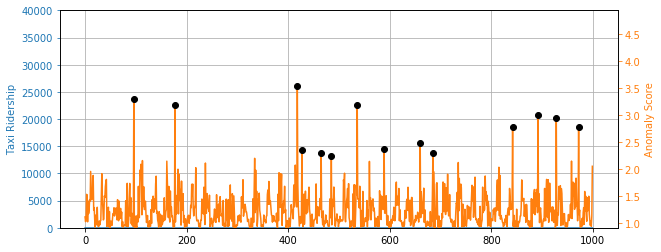

In [31]:
ax2.plot(anomalies.index, anomalies.score, 'ko')
fig

In [33]:
sagemaker.Session(boto_session).delete_endpoint(rcf_inference.endpoint)